# Plots found in Section 6.4 :  Results From the Primary Evaluation

In [ ]:
import math
import os
import pickle
from pathlib import Path

import pandas as pd
import proplot as pplt
from matplotlib import pyplot as plt

from evaluation.fluctuation_analysis.metrics import Metrics
from matplotlib.ticker import MultipleLocator

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = '#fbfbfb'


In [3]:
scenario_short = {
    "CVE-2017-7529": "2017",
    "CVE-2014-0160": "2014",
    "CVE-2012-2122": "2012",
    "Bruteforce_CWE-307": "BF",
    "CWE-89-SQL-injection": "SQL",
    "SQL_Injection_CWE-89": "SQL",
    "PHP_CWE-434": "PHP",
    "CVE-2018-3760": "2018",
    "CVE-2019-5418": "2019",
    "EPS_CWE-434": "EPS",
    "Juice-Shop": "JUIC",
    "ZipSlip": "ZIP",
    "CVE-2020-23839": "CMS",
    "CVE-2020-9484": "TOM",
    "CVE-2020-13942": "UNOM",
    "CVE-2017-12635_6": "CBD",
}

dataset_short = {
    "LID-DS-2019": "19",
    "LID-DS-2021": "21",
}

In [4]:
checkpoint_dir = "final"

scenario_2019 = [
    "CVE-2017-7529",
    "CVE-2012-2122",
    "Bruteforce_CWE-307",
    "CVE-2014-0160",
    "CVE-2018-3760",
    "CVE-2019-5418",
    "SQL_Injection_CWE-89",
    "PHP_CWE-434",
    "EPS_CWE-434",

    #"ZipSlip",
]

scenario_2021 = [
    "CVE-2017-7529",
    "Bruteforce_CWE-307",
    "CVE-2012-2122",
    "CVE-2014-0160",
    "CVE-2020-23839",
    "PHP_CWE-434",
    "CWE-89-SQL-injection",
    "EPS_CWE-434", 
]

datasets = [
    "LID-DS-2019",
    "LID-DS-2021",
]

In [6]:
configs_true = [
    ('TF', 'LID-DS-2021', 'CVE-2017-7529', 5, 16, 2, 2, 0.1, True),
    ('TF', 'LID-DS-2021', 'CVE-2017-7529', 8, 16, 2, 2, 0.1, True),
    ('TF', 'LID-DS-2021', 'CVE-2017-7529', 16, 16, 2, 2, 0.1, True),
    ('TF', 'LID-DS-2019', 'Bruteforce_CWE-307', 5, 16, 2, 2, 0.1, True),
    ('TF', 'LID-DS-2019', 'Bruteforce_CWE-307', 8, 16, 2, 2, 0.1, True),
    ('TF', 'LID-DS-2019', 'Bruteforce_CWE-307', 16, 16, 2, 2, 0.1, True),
]

In [7]:
all_metrics = {}

In [8]:

def load_metrics(config):
    path = os.path.join(checkpoint_dir, "metrics", f"{'_'.join((str(c) for c in config))}.pickle")
    if config in all_metrics:
        return all_metrics[config]
    with open(path, 'rb') as f_in:
        all_metrics[config] = pickle.load(f_in)
    return all_metrics[config]


In [9]:
for conf in configs_true:
    load_metrics(conf)

In [10]:
def early_stopping_min_or_no_improve_last_x(ths, x=10):
    ths_idx_best = 0
    x_since_best = 0
    for i, _th in enumerate(ths):
        if _th < ths[ths_idx_best]:
            ths_idx_best = i
            x_since_best = 0
        else:
            x_since_best += 1
        if x_since_best > x:
            break

    return ths_idx_best

In [11]:
def early_stopping_picked(_conf, _per, x=10, _train=False, _loss=False, _wait=0):
    """
    
    Returns:
        tp_ngs, fp_ngs, dr, epoch, precision, f1
    """
    metrics: list[Metrics] = list(load_metrics(_conf).values())
    if _loss:
        values = [_met.train_loss if _train else _met.val_loss for _met in metrics]
    else:
        values = [_met.threshold_train if _train else _met.threshold for _met in metrics]

    min_loss_idx = early_stopping_min_or_no_improve_last_x(values, x)
    min_loss_idx = min(min_loss_idx + _wait, len(metrics) - 1)
    picked = metrics[min_loss_idx]
    dr = picked.tpr[_per]
    fp_ngs = picked.fp_ngs[_per]
    tp_ngs = picked.tp_ngs[_per]
    precision = picked.precision_ngs[_per]
    f1 = picked.f1_ngs[_per]

    return tp_ngs, fp_ngs, dr, picked.epoch, precision, f1


In [16]:
loss_picked = {}
ths_picked = {}
loss_picked_all = {}
ths_picked_all = {}

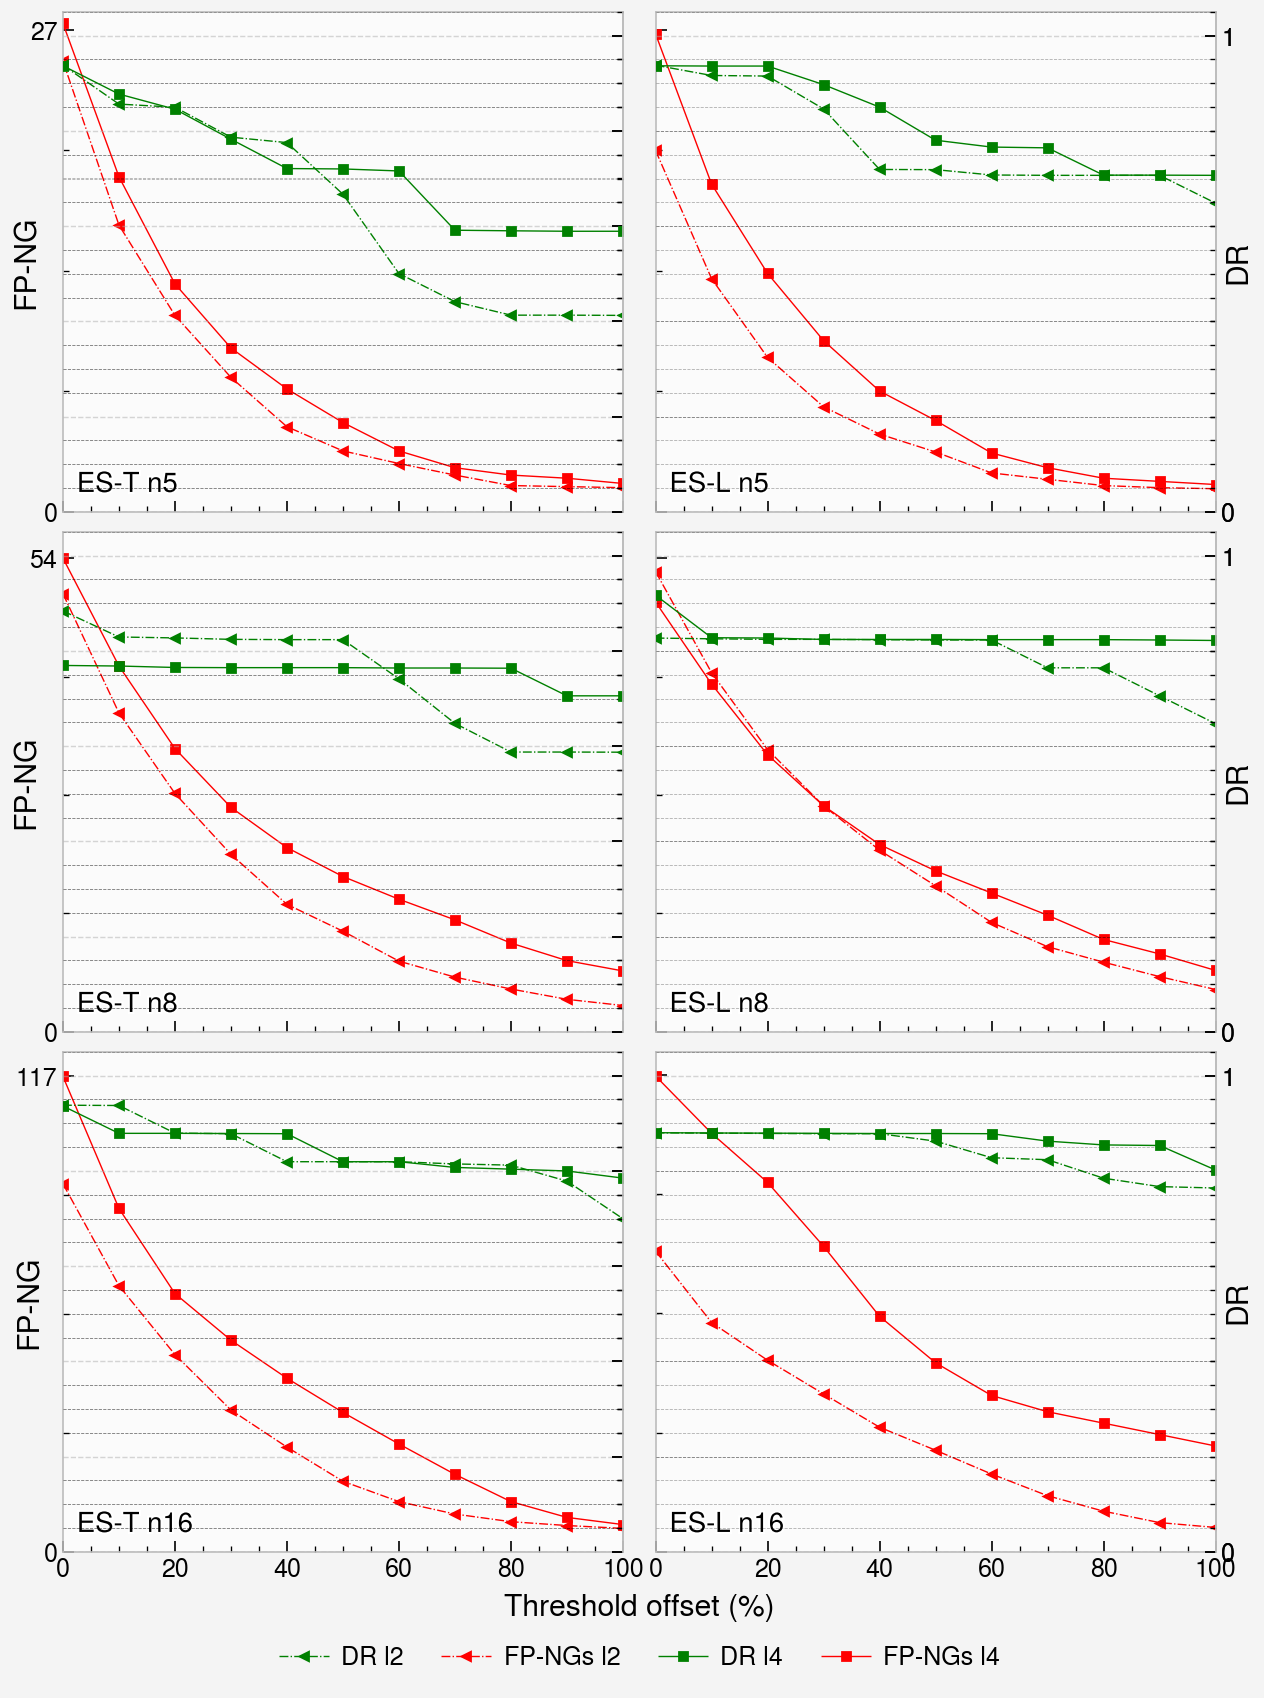

In [18]:
config_to_cfa = {}
def ths_v_loss_over_offset():
    """ Average DR and FP-NG against the threshold offset """
    fig, axs = pplt.subplots(ncols=2, nrows=3, sharex=True, sharey=False, refwidth=2.8, refheight=2.5, innerpad=0.2)
    ax_row_idx = 0
    _m = 16
    for _n in [5, 8, 16]:
        handles_presision = []
        handles = []
        for _l in [2, 4]:
            marker = "<" if _l == 2 else "s"
            linestyle = '-.' if _l == 2 else '-'
            dr_style = {
                "color": 'green',
                "marker": marker,
                "markersize": 3,
                "linestyle": linestyle,
                "linewidth": 0.5
            }
            fp_style = {
                "color": 'red',
                "marker": marker,
                "markersize": 3,
                "linestyle": linestyle,
                "linewidth": 0.5
            }
            _x = 25
            ax_col_idx = 0
            max_fpng = 1
            for loss in [False, True]:
                for train in [False]:
                    results_all = []
                    pers = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
                    for per in pers:
                        _res = []
                        for ds in datasets:
                            if ds == "LID-DS-2019":
                                scenarios = scenario_2019
                            else:
                                scenarios = scenario_2021

                            for scenario in scenarios:
                                conf = ('TF', ds, scenario, _n, _m, _l, _l, 0.1, True)
                                try:
                                    tp_ngs, fp_ngs, dr, epoch, precision, f1 = early_stopping_picked(conf, per, _x, train, loss)

                                    conf_ep_per = conf + (epoch, per)
                                    default_cfa = 0 if fp_ngs == 0 else math.inf
                                    cfa = config_to_cfa.get(conf_ep_per, default_cfa)
                                    _res.append((tp_ngs, fp_ngs, dr, epoch, precision, f1, cfa))
                                except Exception as e:
                                    print("failed: ", conf, e)

                        res_pd = pd.DataFrame(_res, columns=["tp_ngs", "fp_ngs", "dr", "epoch", "precision", "f1", "cfa"])
                        result = res_pd["tp_ngs"].mean(), res_pd["fp_ngs"].mean(), res_pd["dr"].mean(), res_pd["precision"].mean(), res_pd["f1"].mean(), res_pd["cfa"].mean()
                        results_all.append(result)
                        if loss:
                            loss_picked[(_n, _l,_m, per)] = result
                            loss_picked_all[(_n, _l,_m, per)] = [(_r[1],_r[2]) for _r in _res]
                        else:
                            ths_picked[(_n, _l,_m, per)] = result
                            ths_picked_all[(_n, _l,_m, per)] = [(_r[1],_r[2]) for _r in _res]

                    ax = axs[(ax_row_idx, ax_col_idx)]
                    ax.grid(False)
                    h1 = ax.plot(pers, [r[1] for r in results_all], label=f"FP-NGs l{_l}", **fp_style)
                    ax_dr = ax.twinx()
                    h2 = ax_dr.plot(pers, [r[2] for r in results_all], label=f"DR l{_l}", **dr_style)
                    ax_dr.set_ylim(0, 1)
                    ax_dr.grid(True, which='both', axis='both', linestyle='--', alpha=0.3)
                    if not loss:
                        # no y axis
                        handles.append(h2)
                        handles.append(h1)
                        ax_dr.set_yticklabels([])
                    else:
                        if _l == 4:
                            ax_dr.set_ylabel("DR")
                            ax_dr.format(ylabelpad=-4)
                            ax_dr.set_ylim(0,1)

                    ax_dr.set_ylim(0, 1.05)
                    if loss:
                        ax_dr.set_yticks([0,1])
                        
                    if _l == 4:
                        max_fpng = max(round(max([r[1] for r in results_all])), max_fpng)
                        ax.set_yticks([0, max_fpng ])
                        ax.set_ylim([0,  round(max_fpng * 1.05)])

                        ax_dr.grid(False)
                        ax_dr.yaxis.set_minor_locator(MultipleLocator(0.05))
                        ax_dr.grid(True, which='both', axis='y', linestyle='--', alpha=0.3)
                        if loss:
                            ax_dr.set_ylabel("DR")
                            ax_dr.format(ylabelpad=-4)


                    if not loss:
                        # no y axis
                        ax_dr.set_yticklabels([])
                    else:
                        ax.set_yticklabels([])
                    ax.format(title=f"{'ES-L' if loss else 'ES-T'} n{_n}")  # - avg e{avg_epoch:.1f}±{std_epoch:.1f}")

                    ax_col_idx += 1
        ax_row_idx += 1

    all_handles = handles + handles_presision
    fig.legend(
        handles=all_handles,
        loc='b',
        ncols=len(all_handles),
        frame=False,
        pad=1,
    )
    
    axs[:,0].format(
        ylabel="FP-NG",
        ylabelpad=-4,
    )

    axs[-1,:].format(
        xlabel="Threshold offset (%)",
    )
    axs[-1,0].format(
        ylabelpad=-10,
    )

    fig.format(
        titleloc='ll',
    )

    path = 'final_plots/ths_v_loss/precision_ngs_over_ths_offset.png'
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(path, dpi=400, bbox_inches='tight')

ths_v_loss_over_offset()


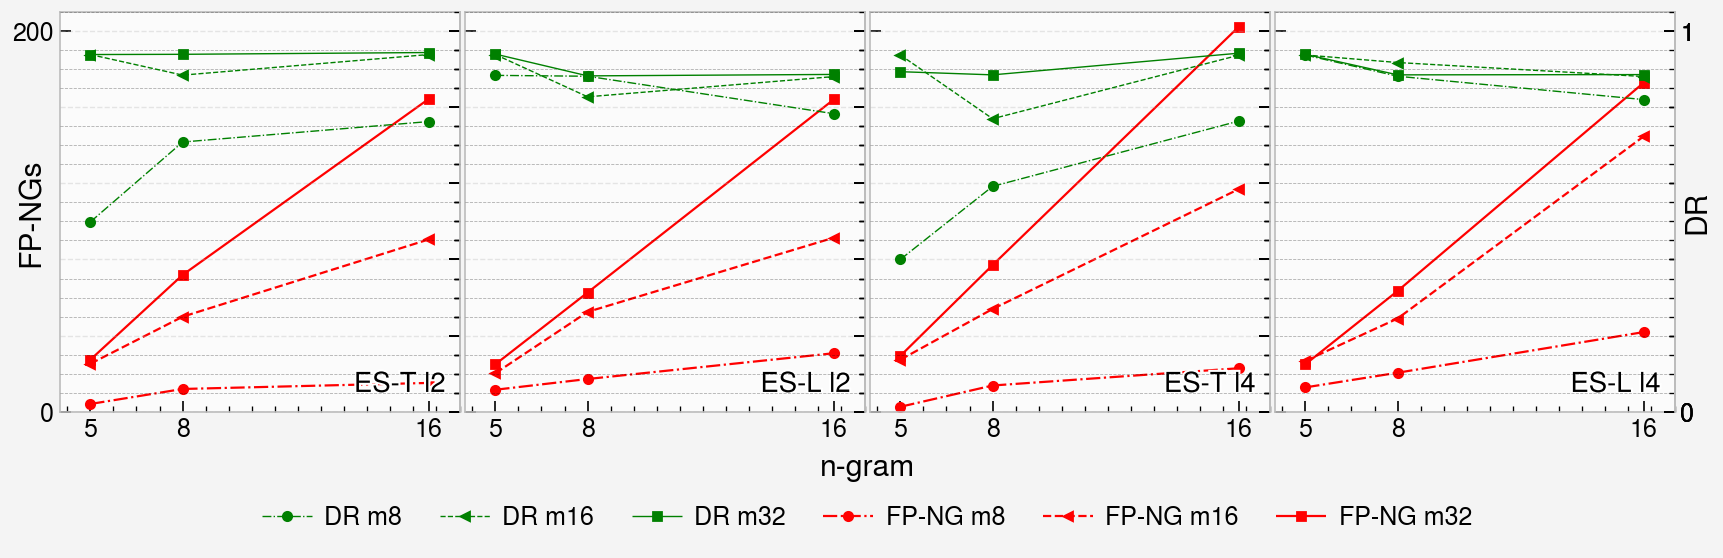

In [36]:
def ths_v_loss_v_emb_v_l_over_ngs(_ngs=None):
    """ Mean DR (green) and FP-NG (red) of all hyperparameters, averaged over 17 scenarios. """
    _ngs = _ngs or [5, 8, 16]
    losses = [False, True]
    per = 0
    train = False

    fig, axs = pplt.subplots(
        ncols=4,
        nrows=1,
        sharex=True,
        sharey=True,
        refwidth=2,
        refheight=2, 
        innerpad=0.2
    )
    ax_row_idx = 0
    for _l in [2, 4]:
        ax_col_idx = 0
        for loss in losses:
            handles = []
            for _m in [8, 16, 32]:
                marker = "o" if _m == 8 else ("<" if _m == 16 else "s")
                linestyle = '-.' if _m == 8 else ('--' if _m == 16 else '-')
                color = 'green'
                dr_style = {
                    "color": color,
                    "marker": marker,
                    "markersize": 3,
                    "linestyle": linestyle,
                    "linewidth": 0.5
                }
                _x = 25
                results_all = []
                for _n in _ngs:
                    _res = []
                    for ds in datasets:
                        if ds == "LID-DS-2019":
                            scenarios = scenario_2019
                        else:
                            scenarios = scenario_2021
                        for scenario in scenarios:
                            conf = ('TF', ds, scenario, _n, _m, _l, _l, 0.1, True)
                            tp_ngs, fp_ngs, dr, epoch, precision, f1 = early_stopping_picked(
                                conf,
                                per,
                                _x,
                                train,
                                loss
                            )
                            _res.append((tp_ngs, fp_ngs, dr, epoch, precision, f1))

                    res = pd.DataFrame(_res, columns=["tp_ngs", "fp_ngs", "dr", "epoch", "precision", "f1"])
                    result = res["tp_ngs"].mean(), res["fp_ngs"].mean(), res["dr"].mean(), res["precision"].mean(), res[
                        "f1"].mean()
                    results_all.append(result)

                curr=  2 * ax_row_idx + ax_col_idx
                ax = axs[curr]
                ax.grid(False)
                ax.yaxis.set_major_locator(MultipleLocator(50))
                ax.yaxis.set_minor_locator(plt.NullLocator())

                h1 = ax.plot(
                    _ngs,
                    [r[1] for r in results_all],
                    label=f"FP-NG m{_m}",
                    color='red',
                    marker=marker,
                    markersize=3,
                    linestyle=linestyle,
                    linewidth=0.8,
                    alpha=1
                )

                ax.format(title=f"{'ES-L' if loss else 'ES-T'} l{_l}") 
                ax.set_xticks(_ngs)
                ax.set_xlim(4, 17)
                ax.set_yticks([0,200])
                ax.set_yticklabels([0,200])
                ax.set_ylim([0,210])
                
                ax_dr = ax.twinx()
                h2 = ax_dr.plot(_ngs, [r[2] for r in results_all], label=f"DR m{_m}", **dr_style)

                ax_dr.set_ylim(0, 1.05)
                if curr == 3:
                    ax_dr.set_yticks([0,1])
                if _m == 8:
                    ax_dr.grid(False)
                    ax_dr.yaxis.set_minor_locator(MultipleLocator(0.05))
                    ax_dr.grid(True, which='both', axis='y', linestyle='--', alpha=0.3)
                    if curr == 3:
                        ax_dr.set_ylabel("DR")
                        ax_dr.format(ylabelpad=-4)


                if curr != 3:
                    ax_dr.set_yticklabels([])

                handles.append(h2)
                handles.append(h1)

            ax_col_idx += 1

        ax_row_idx += 1

    handles_order = [0, 2, 4, 1, 3, 5]
    all_handles = handles
    all_handles = [all_handles[i] for i in handles_order]
    fig.legend(
        handles=all_handles,
        loc='b',
        ncols=len(all_handles),
        frame=False,
        pad=1
    )

    fig.format(
        titleloc='lr',
    )

    axs[:, 0].format(ylabel="FP-NGs", ylabelpad=-12)
    axs[-1, :].format(xlabel="n-gram")
    path = 'final_plots/emb/small_all_drs_cfa_over_ngs.png'
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(path, dpi=400, bbox_inches='tight')


ths_v_loss_v_emb_v_l_over_ngs()



DONE
DONE


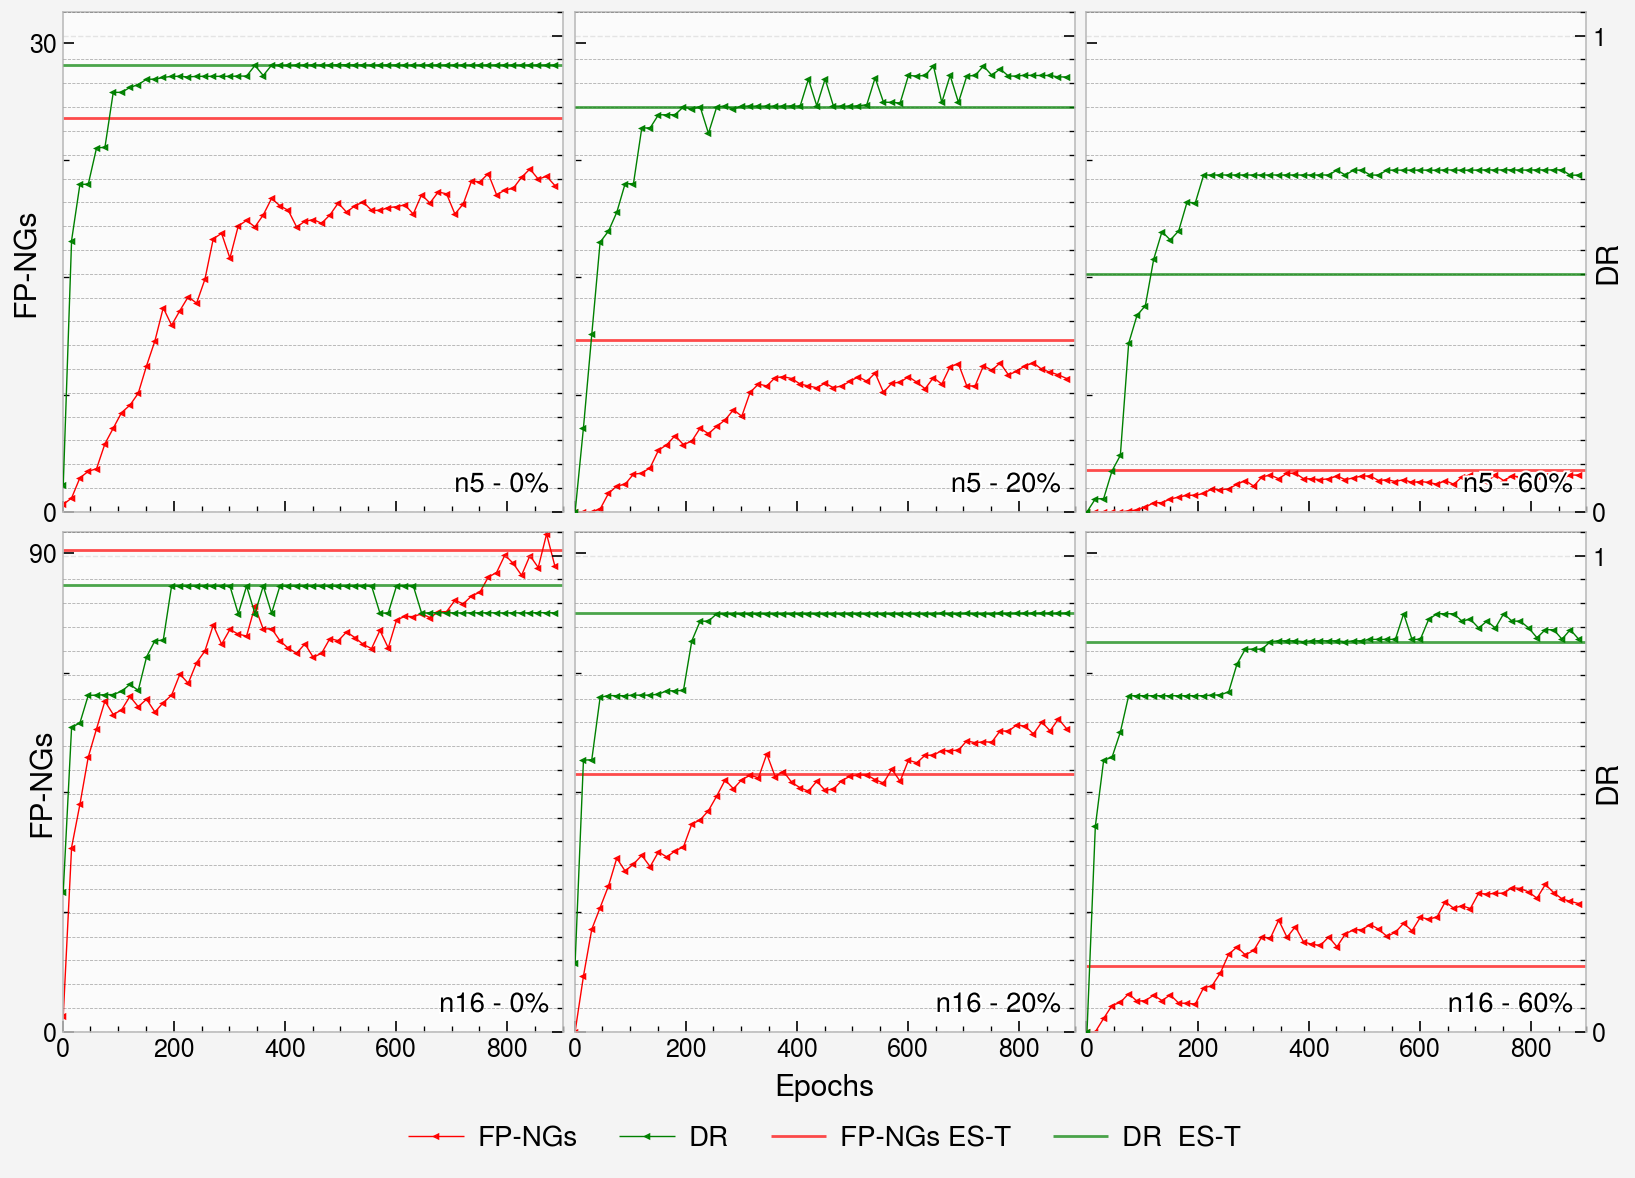

In [24]:
def plot_avg_dr_fpngs_over_fixed_epochs():
    """ Average DR and FP-NG after training for a fixed number of epochs.  """
    fig, axs = pplt.subplots(ncols=3, nrows=2, sharex=True, sharey=False, refwidth=2.5, refheight=2.5, innerpad=0.2 )
    ax_row_idx = 0
    use_loss = True
    use_loss = False
    _m = 16
    for _n in [5, 16]:
        handles = []
        for _l in [2]:
            marker = "<" if _l == 2 else "s"
            linestyle = '-' if _l == 2 else '-.'
            dr_style = {
                "color": 'green',
                "marker": marker,
                "markersize": 1,
                "linestyle": linestyle,
                "linewidth": 0.5
            }
            fp_style = {
                "color": 'red',
                "marker": marker,
                "markersize": 1,
                "linestyle": linestyle,
                "linewidth": 0.5
            }
            ax_col_idx = 0
            max_fpng = 1
            for _per in [0, 20, 60]:
                results_all = []
                epochs = list(range(1, 900, 15))
                for _epoch in epochs:
                    res = []
                    for ds in ["LID-DS-2019", "LID-DS-2021"]:
                        if ds == "LID-DS-2019":
                            scenarios = scenario_2019
                        else:
                            scenarios = scenario_2021

                        for scenario in scenarios:
                            conf = ('TF', ds, scenario, _n, 16, _l, _l, 0.1, True)
                            metrics: dict[int, Metrics] = load_metrics(conf)
                            picked = metrics[_epoch]
                            dr = picked.tpr[_per]
                            fp_ngs = picked.fp_ngs[_per]
                            tp_ngs = picked.tp_ngs[_per]
                            precision = picked.precision_ngs[_per]
                            f1 = picked.f1_ngs[_per]
                            res.append((tp_ngs, fp_ngs, dr, _epoch, precision, f1))

                    res = pd.DataFrame(res, columns=["tp_ngs", "fp_ngs", "dr", "epoch", "precision", "f1"])
                    results_all.append(
                        (res["tp_ngs"].mean(), res["fp_ngs"].mean(), res["dr"].mean(), res["precision"].mean(),
                         res["f1"].mean())
                    )

                ax = axs[(ax_row_idx, ax_col_idx)]
                ax.grid(False)
                h1 = ax.plot(epochs, [r[1] for r in results_all], label=f"FP-NGs", **fp_style)
                ax_dr = ax.twinx()
                h2 = ax_dr.plot(epochs, [r[2] for r in results_all], label=f"DR", **dr_style)
                ax_dr.set_ylim(0, 1)
                ax_dr.grid(True, which='both', axis='both', linestyle='--', alpha=0.3)
                if ax_col_idx == 2 and _l == 2:
                    print("DONE")
                    ax_dr.set_ylabel("DR")
                    ax_dr.format(ylabelpad=-4)
                if ax_col_idx != 0:
                    ax.set_yticklabels([])

                ax_dr.set_ylim(0, 1.05)
                ax_dr.set_yticks([0,1])
                if ax_col_idx != 2:
                    ax_dr.set_yticklabels([])

                ax_dr.grid(False)
                ax_dr.yaxis.set_minor_locator(MultipleLocator(0.05))
                ax_dr.grid(True, which='both', axis='y', linestyle='--', alpha=0.3)

                early_stopping = loss_picked[(_n, _l, _m, _per)] if use_loss else ths_picked[(_n, _l,_m, _per)]
                h1_l = ax.hlines(early_stopping[1], 0, 900,  label=f"FP-NGs {'ES-L' if use_loss else 'ES-T'}", alpha=0.7, linestyles=linestyle, color='red', linewidth=1)
                h2_l = ax_dr.hlines(early_stopping[2], 0, 900,  label=f"DR  {'ES-L' if use_loss else 'ES-T'}", alpha=0.7, linestyles=linestyle, color='green', linewidth=1)
                ax.format(title=f"n{_n} - {_per}%", titleloc='ll')
                
                max_fpng = max(round(max([r[1] for r in results_all]  + [early_stopping[1]]), -1), max_fpng)
                ax.set_yticks([0, max_fpng ])
                ax.set_ylim([0,  round(max_fpng * 1.05)])

                ax_col_idx += 1
        
            handles.append(h1)
            handles.append(h2)
            handles.append(h1_l)
            handles.append(h2_l)
            
        ax_row_idx += 1

    with pplt.rc.context({'legend.fontsize': 10}):
        fig.legend(
            handles=handles,
            loc='b',
            ncols=len(handles),
            frame=False,
            pad=1
        )

    axs[:, 0].format(ylabel="FP-NGs", ylabelpad=-4)
    axs[-1, :].format(xlabel="Epochs")

    axs[-1,0].format(
        ylabelpad=-10,
    )
    fig.format(
        titleloc='lr',
    )

    path = f'final_plots/ths_v_loss/fp_ngs_over_epoch_offset_{"loss" if use_loss else "ths"}.png'
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(path, dpi=400, bbox_inches='tight')

plot_avg_dr_fpngs_over_fixed_epochs()

DONE
DONE
DONE
DONE
DONE
DONE


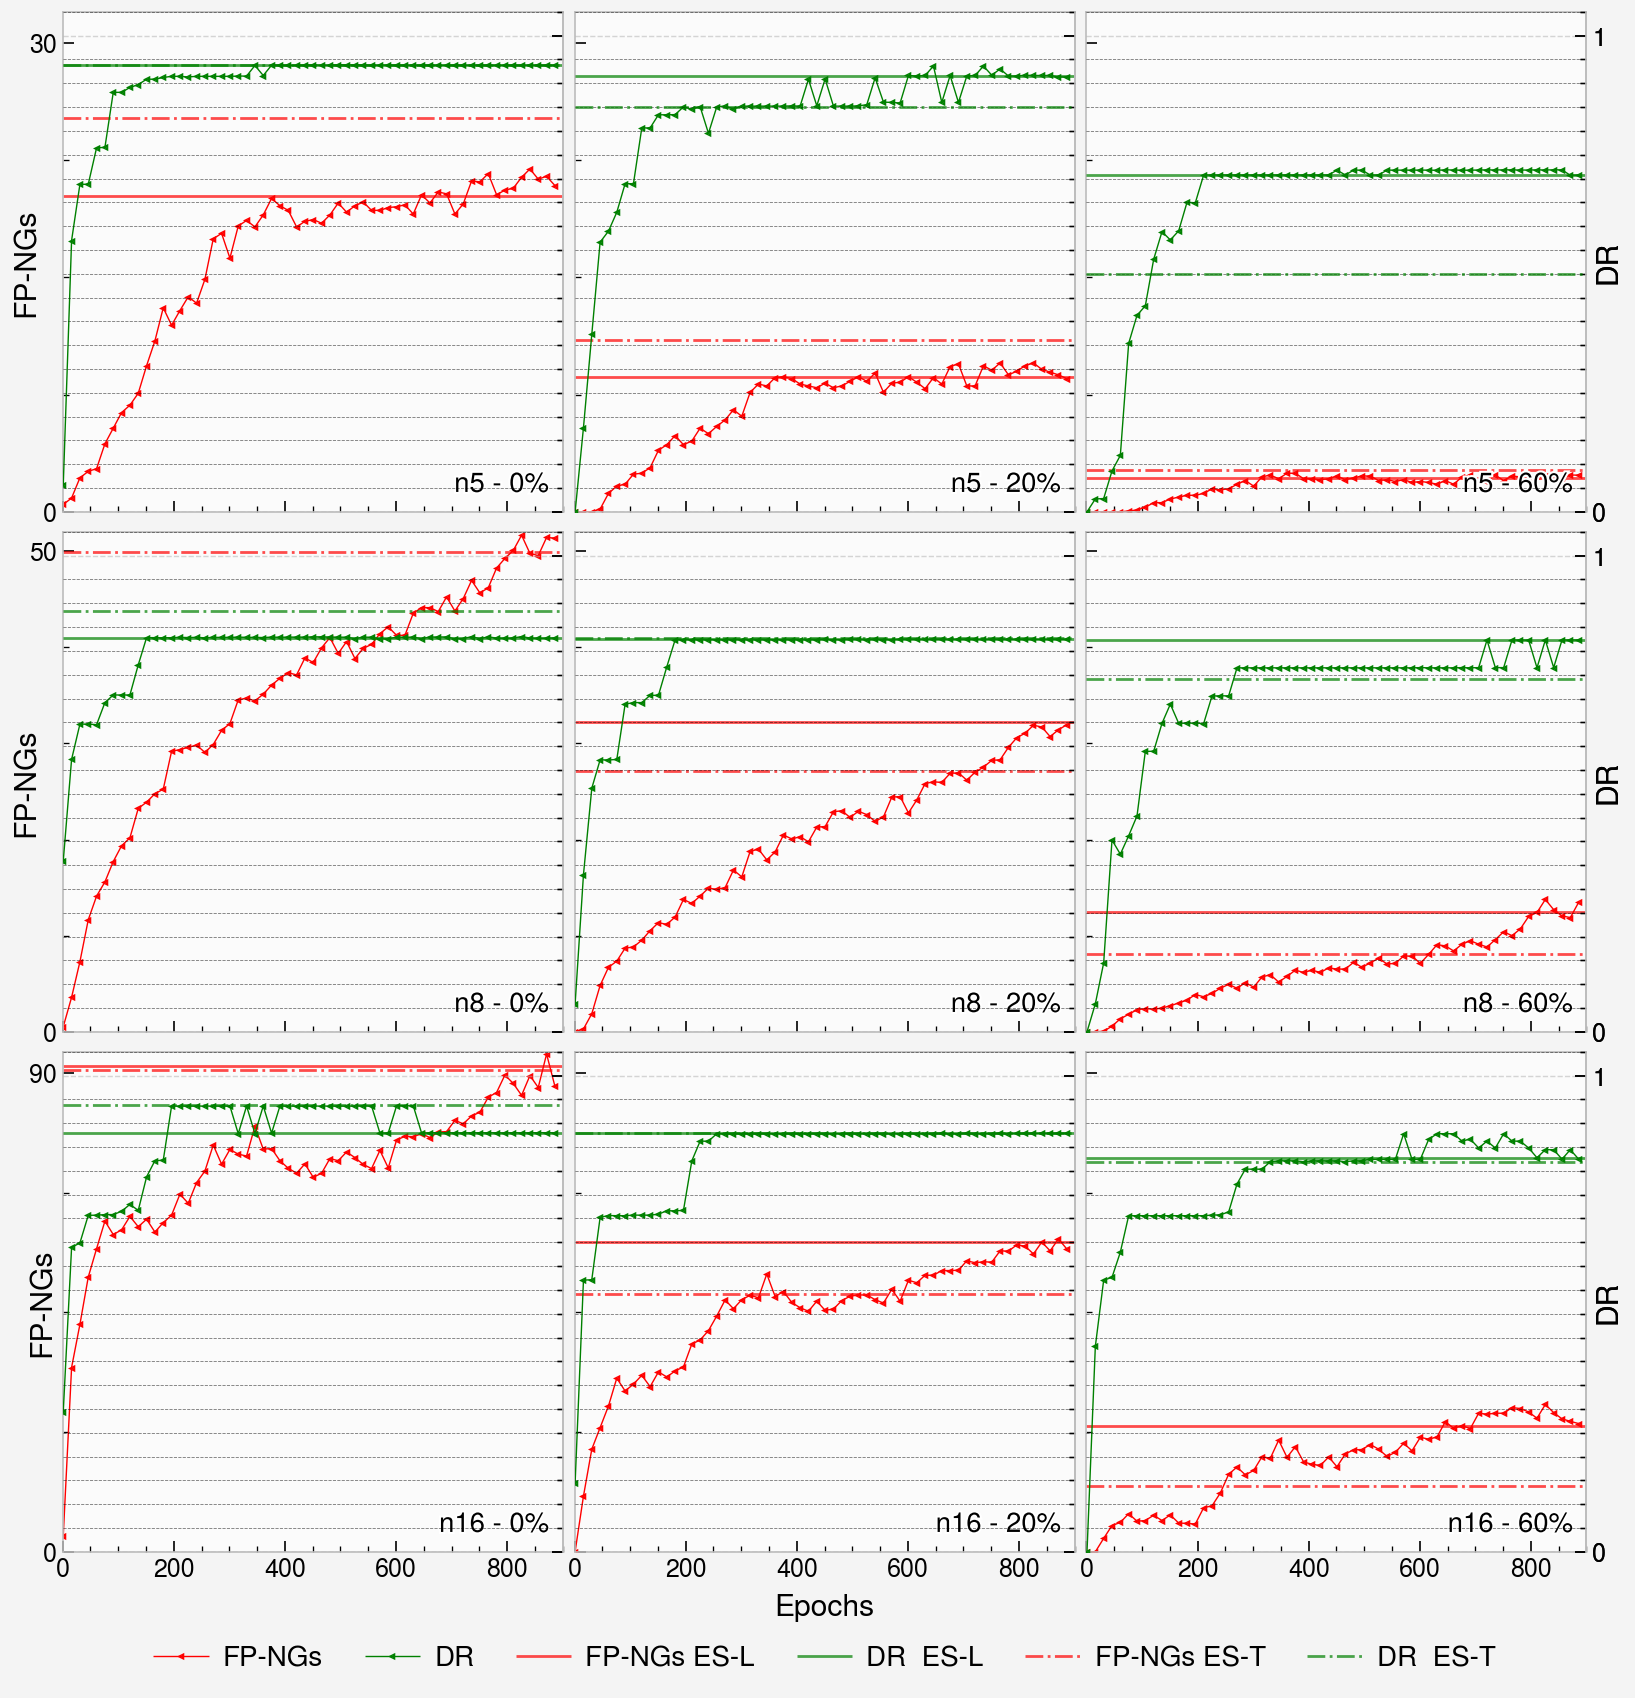

In [29]:
def plot_avg_dr_fpngs_over_fixed_epochs_appendix():
    """ Average DR and FP-NG after training for a fixed number of epochs. """
    fig, axs = pplt.subplots(ncols=3, nrows=3, sharex=True, sharey=False, refwidth=2.5, refheight=2.5, innerpad=0.2 )
    ax_row_idx = 0
    use_loss = False
    _m = 16
    for _n in [5, 8, 16]:
        handles = []
        for use_loss in [True, False]:
            for _l in [2]:
                marker = "<" if use_loss else "s"
                linestyle = '-' if use_loss else '-.'
                dr_style = {
                    "color": 'green',
                    "marker": marker,
                    "markersize": 1,
                    "linestyle": linestyle,
                    "linewidth": 0.5
                }
                fp_style = {
                    "color": 'red',
                    "marker": marker,
                    "markersize": 1,
                    "linestyle": linestyle,
                    "linewidth": 0.5
                }
                ax_col_idx = 0
                max_fpng = 1
                for _per in [0, 20, 60]:
                    results_all = []
                    epochs = list(range(1, 900, 15))
                    for _epoch in epochs:
                        res = []
                        for ds in ["LID-DS-2019", "LID-DS-2021"]:
                            if ds == "LID-DS-2019":
                                scenarios = scenario_2019
                            else:
                                scenarios = scenario_2021

                            for scenario in scenarios:
                                conf = ('TF', ds, scenario, _n, 16, _l, _l, 0.1, True)
                                metrics: dict[int, Metrics] = load_metrics(conf)
                                picked = metrics[_epoch]
                                dr = picked.tpr[_per]
                                fp_ngs = picked.fp_ngs[_per]
                                tp_ngs = picked.tp_ngs[_per]
                                # precision = picked.precision[_per]
                                precision = picked.precision_ngs[_per]
                                f1 = picked.f1_ngs[_per]
                                res.append((tp_ngs, fp_ngs, dr, _epoch, precision, f1))

                        res = pd.DataFrame(res, columns=["tp_ngs", "fp_ngs", "dr", "epoch", "precision", "f1"])
                        results_all.append(
                            (res["tp_ngs"].mean(), res["fp_ngs"].mean(), res["dr"].mean(), res["precision"].mean(),
                             res["f1"].mean())
                        )
                        # epochs.append(res["epoch"].mean())

                    ax = axs[(ax_row_idx, ax_col_idx)]
                    ax.grid(False)
                    if use_loss:
                        h1 = ax.plot(epochs, [r[1] for r in results_all], label=f"FP-NGs", **fp_style)
                    ax_dr = ax.twinx()
                    if use_loss:
                        h2 = ax_dr.plot(epochs, [r[2] for r in results_all], label=f"DR", **dr_style)
                    ax_dr.set_ylim(0, 1)
                    ax_dr.grid(True, which='both', axis='both', linestyle='--', alpha=0.3)
                    if ax_col_idx == 2 and _l == 2:
                        ax_dr.set_ylabel("DR")
                        ax_dr.format(ylabelpad=-4)
                    if ax_col_idx != 0:
                        ax.set_yticklabels([])

                    ax_dr.set_ylim(0, 1.05)
                    ax_dr.set_yticks([0,1])
                    if ax_col_idx != 2:
                        ax_dr.set_yticklabels([])

                    ax_dr.grid(False)
                    ax_dr.yaxis.set_minor_locator(MultipleLocator(0.05))
                    ax_dr.grid(True, which='both', axis='y', linestyle='--', alpha=0.3)

                    early_stopping = loss_picked[(_n, _l, _m, _per)] if use_loss else ths_picked[(_n, _l,_m, _per)]
                    h1_l = ax.hlines(early_stopping[1], 0, 900,  label=f"FP-NGs {'ES-L' if use_loss else 'ES-T'}", alpha=0.7, linestyles=linestyle, color='red', linewidth=1)
                    h2_l = ax_dr.hlines(early_stopping[2], 0, 900,  label=f"DR  {'ES-L' if use_loss else 'ES-T'}", alpha=0.7, linestyles=linestyle, color='green', linewidth=1)
                    ax.format(title=f"n{_n} - {_per}%", titleloc='ll')

                    max_fpng = max(round(max([r[1] for r in results_all]  + [early_stopping[1]]), -1), max_fpng)
                    ax.set_yticks([0, max_fpng ])
                    ax.set_ylim([0,  round(max_fpng * 1.05)])

                    ax_col_idx += 1

                if use_loss:
                    handles.append(h1)
                    handles.append(h2)
                handles.append(h1_l)
                handles.append(h2_l)

        ax_row_idx += 1

    with pplt.rc.context({'legend.fontsize': 10}):
        fig.legend(
            handles=handles,
            loc='b',
            ncols=len(handles),
            frame=False,
            pad=1
        )

    axs[:, 0].format(ylabel="FP-NGs", ylabelpad=-4)
    axs[-1, :].format(xlabel="Epochs")

    axs[-1,0].format(
        ylabelpad=-10,
    )
    fig.format(
        titleloc='lr',
    )

    path = f'final_plots/ths_v_loss/fp_ngs_over_epoch_offset_BOTH_appendix.png'
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(path, dpi=400, bbox_inches='tight')


plot_avg_dr_fpngs_over_fixed_epochs_appendix()